# Generating an Adaptive Mesh Around a Road Network

This notebook showcases Python code for creating a mesh that covers a road network, with finer details near the roads. The mesh utilizes a quadtree structure and allows users to tailor parameters such as the size of the smallest meshes and the number of refinement levels. It's worth noting that the code provided relies exclusively on numpy, geopandas, and shapely libraries. As a demonstration, we apply this method to the road network of Metz, obtained using the ``osmnx`` package.

Cyril Joly

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import box
from tqdm.auto import tqdm


class AdaptiveMesh:
    """
    Generates a refined mesh (quadtree type) by approaching the strands. The smallest cells are squares
    of size `dmin`, the largest cells are squares of size dmin x 2**`refinement_levels`.
    The coarsest mesh extends beyond the network boundaries by a distance `margin_background`.
    """

    @staticmethod
    def _generate_grid(x, y, delta, crs):
        """
        Generates a grid of square cells given arrays of x and y coordinates.

        Args:
            x (numpy.ndarray): Array of x coordinates.
            y (numpy.ndarray): Array of y coordinates.
            delta (float): Size of the cells.
            crs (CRS): Coordinate reference system.

        Returns:
            geopandas.GeoDataFrame: GeoDataFrame representing the grid of cells.
        """
        ret = []
        for xc in x:
            for yc in y:
                ret.append(box(xc-delta/2, yc-delta/2, xc+delta/2, yc+delta/2))
        return gpd.GeoDataFrame(geometry=ret, crs=crs)

    @staticmethod
    def _divide_polygon(p, n):
        """
        Divides a polygon into smaller polygons.

        Args:
            p (shapely.geometry.Polygon): Polygon to be divided.
            n (int): Number of divisions along each axis.

        Returns:
            list: List of smaller polygons.
        """
        xmin, ymin, xmax, ymax = p.bounds
        dx = (xmax-xmin)/n
        dy = (ymax-ymin)/n
        ret = []
        for j in range(n):
            for k in range(n):
                ret.append(box(xmin+j*dx, ymin+k*dy, xmin+(j+1)*dx, ymin+(k+1)*dy))
        return ret

    @classmethod
    def compute(cls, network, dmin, refinement_levels, margin_background) -> gpd.GeoDataFrame:
        """
        Computes the adaptive mesh based on the provided network and parameters.

        Args:
            network (geopandas.GeoDataFrame): Network data representing roads or similar features.
            dmin (float): Minimum cell size.
            refinement_levels (int): Number of refinement levels.
            margin_background (float): Distance by which the coarsest mesh extends beyond the network boundaries.

        Returns:
            geopandas.GeoDataFrame: GeoDataFrame representing the computed mesh.
        """
        dmin = float(dmin)
        dmax = float(dmin)*(2**(refinement_levels-1))
        margin_background = float(margin_background)
        crs = network.crs

        xmin, ymin, xmax, ymax = network.total_bounds
        x0 = np.arange(xmin-margin_background-dmax, xmax+dmax+margin_background, dmax)
        y0 = np.arange(ymin-margin_background-dmax, ymax+dmax+margin_background, dmax)
        x0 = x0 - (np.median(x0)-(xmin+xmax)/2)
        y0 = y0 - (np.median(y0)-(ymin+ymax)/2)

        delta = dmax
        grid = cls._generate_grid(x0, y0, delta, crs).reset_index()
        grid['level'] = 0

        ret = []

        for k in tqdm(range(refinement_levels-1)):
            network_k = gpd.GeoDataFrame(geometry=network.buffer(delta/2**k))

            intersection = gpd.sjoin(grid, network_k, how='inner').drop_duplicates(subset='index')
            index_intersection = intersection['index'].values

            ret.append(grid[~grid['index'].isin(index_intersection)])

            next_grid = []
            for p in grid[grid['index'].isin(index_intersection)].geometry:
                next_grid.extend(cls._divide_polygon(p, 2))

            grid = gpd.GeoDataFrame(geometry=next_grid, crs=crs).reset_index()
            grid['level'] = k+1
        ret.append(grid)
        return pd.concat(ret).drop(columns='index').reset_index(drop=True)


def network_from_place(place, crs=None, return_graph=False, timeout=180) -> gpd.GeoDataFrame:
    ox.settings.log_console = False
    ox.settings.use_cache = False
    ox.settings.requests_timeout = timeout

    G = ox.graph_from_place(place, network_type='drive')
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)
    _, gdf_edges = ox.graph_to_gdfs(G)
    if crs is not None:
        gdf_edges.to_crs(crs, inplace=True)
    if return_graph:
        return gdf_edges, G
    else:
        return gdf_edges

# 1. Download of the road network with ``osmnx``

In [2]:
CRS = 2154

In [3]:
place = 'Metz'
road_network = network_from_place(place=place, crs=CRS)
road_network.sample(3)

,,,osmid,oneway,lanes,ref,name,highway,maxspeed,reversed,length,bridge,geometry,speed_kph,travel_time,width,tunnel,access,junction
u,v,key,,,,,,,,,,,,,,,,,
660838414,660838413,0,51791676,False,NaN,NaN,Rue des Couteliers,unclassified,50,True,269.124,NaN,"LINESTRING (937015.979 6895566.801, 937011.273...",50.0,19.4,NaN,NaN,NaN,NaN
8108595193,80316261,0,870419317,False,NaN,NaN,NaN,secondary_link,NaN,True,7.906,NaN,"LINESTRING (931383.053 6893729.864, 931375.139...",50.0,0.6,NaN,NaN,NaN,NaN
660832334,660832334,0,51791156,False,NaN,NaN,Allée des Bosquets,residential,30,False,65.799,NaN,"LINESTRING (937142.567 6892854.433, 937150.611...",30.0,7.9,NaN,NaN,NaN,NaN


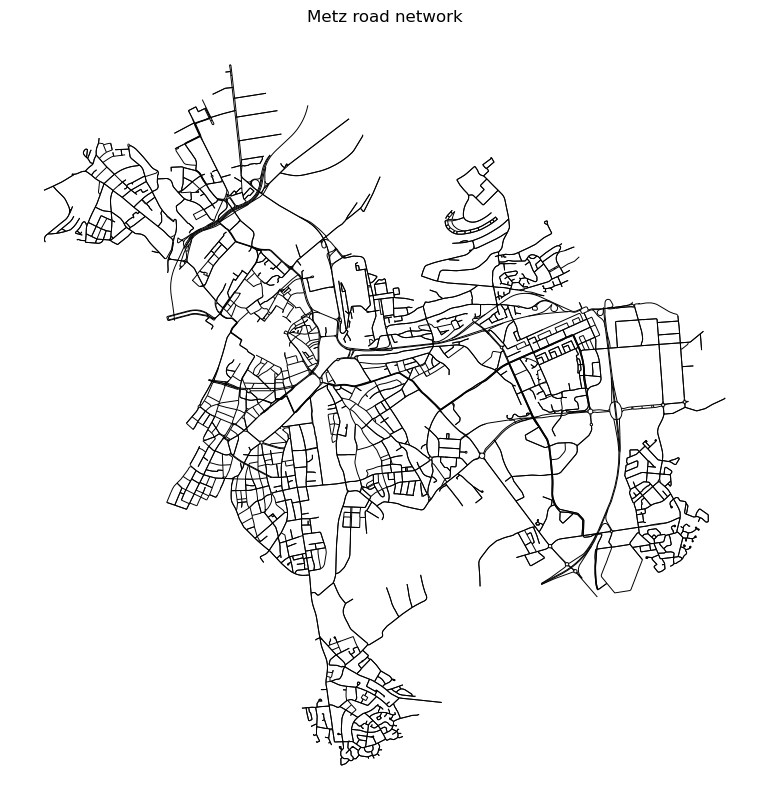

In [4]:
road_network.plot(figsize=(10, 10), ec='k', lw=0.7)
plt.title(f'{place} road network')
plt.gca().axis('off')
plt.show()

# Computation of the adaptive mesh

In [5]:
mesh = AdaptiveMesh.compute(network=road_network, dmin=25, refinement_levels=7, margin_background=1e2)
mesh.sample(3)

  0%|          | 0/6 [00:00<?, ?it/s]

,geometry,level
6391,"POLYGON ((929766.022 6897735.575, 929766.022 6...",6
26300,"POLYGON ((931716.022 6896510.575, 931716.022 6...",6
20998,"POLYGON ((932791.022 6893210.575, 932791.022 6...",6


Display of the road network and the computed mesh: each color stands for a different level of refinement.

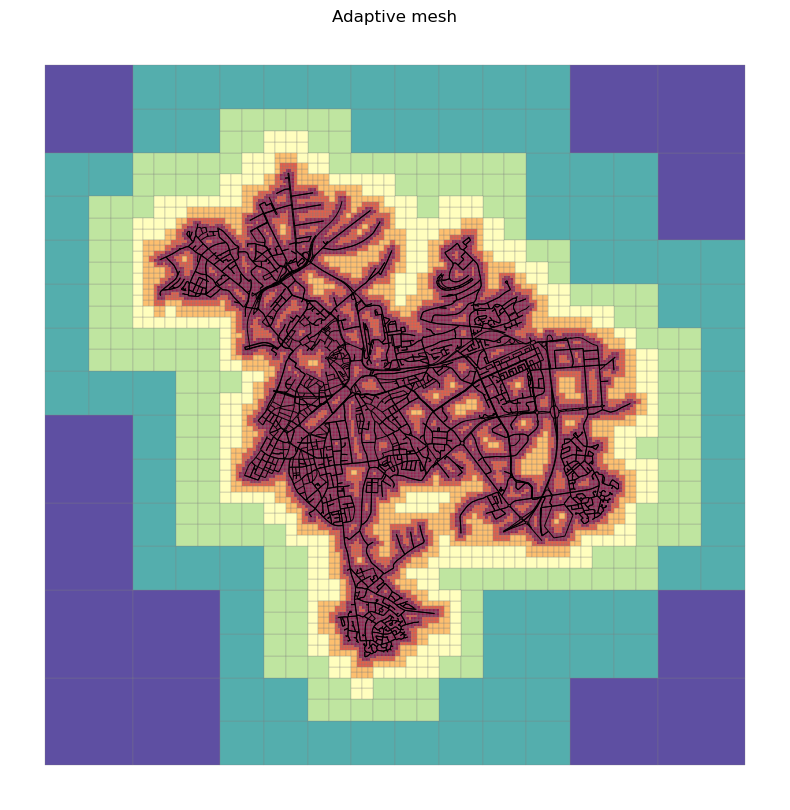

In [6]:
mesh.plot(figsize=(10, 10), ec='grey', lw=0.2, column='level', cmap='Spectral_r')
road_network.plot(ax=plt.gca(), ec='k', lw=0.7)
plt.title("Adaptive mesh")
plt.gca().axis('off')
plt.show()